In [1]:
pip install pyepo

Note: you may need to restart the kernel to use updated packages.


Todo la informacion fue extraida de https://khalil-research.github.io/PyEPO y https://github.com/khalil-research/PyEPO?tab=readme-ov-file

In [14]:
import pyepo

In [16]:
import pyepo
# generate data
grid = (7,7) # grid size
num_data = 1000 # number of training data
num_feat = 7 # size of feature
deg = 4 # polynomial degree
e = 0.5 # noise width
feats, costs = pyepo.data.shortestpath.genData(num_data+1000, num_feat, grid, deg, e, seed=73)
#73 Sheldon Cooper reference

Construir el Modelo

In [19]:
import pyepo

grid = (7,7) # network grid
optmodel = pyepo.model.grb.shortestPathModel(grid) # build model

Dataset y Data Loader


-Dataset es una clase en PyTorch que almacena las muestras de datos y sus etiquetas(features) correspondientes.

-DataLoader se utiliza para acceder de manera eficiente a las muestras de datos almacenadas en optDataset.

In [24]:
# split train test data
from sklearn.model_selection import train_test_split
x_train, x_test, c_train, c_test = train_test_split(feats, costs, test_size=1000, random_state=73)

In [26]:
# get optDataset
dataset_train = pyepo.data.dataset.optDataset(optmodel, x_train, c_train)
dataset_test = pyepo.data.dataset.optDataset(optmodel, x_test, c_test)

Optimizing for optDataset...


100%|██████████| 1000/1000 [00:04<00:00, 207.63it/s]


Optimizing for optDataset...


100%|██████████| 1000/1000 [00:05<00:00, 184.81it/s]


In [27]:
# set data loader
from torch.utils.data import DataLoader
batch_size = 32
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

Generar Datos para el Problema del Camino Más Corto:

Regresion lineal en Pytorch

In [30]:
from torch import nn

# build linear model
class LinearRegression(nn.Module):

    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(num_feat, (grid[0]-1)*grid[1]+(grid[1]-1)*grid[0])

    def forward(self, x):
        out = self.linear(x)
        return out

In [31]:
import torch
# init model
reg = LinearRegression()

-Entrenamiento y testeo

To calculate regret, ``pyepo.metric.regret`` requires:
- ``predmodel``: a regression neural network for cost prediction
- ``optmodel``: an PyEPO optimization model
- ``dataloader``: PyTorch dataloader from optDataset to evaluate

The following code block is an example:

In [34]:
import pyepo
regret = pyepo.metric.regret(reg, optmodel, loader_test)

Funciones para entrenar el modelo con diferentes metodos

In [36]:
import time

# train model
def trainModel(reg, loss_func, method_name, num_epochs=20, lr=1e-2):
    # set adam optimizer
    optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
    # train mode
    reg.train()
    # init log
    loss_log = []
    loss_log_regret = [pyepo.metric.regret(reg, optmodel, loader_test)]
    # init elpased time
    elapsed = 0
    for epoch in range(num_epochs):
        # start timing
        tick = time.time()
        # load data
        for i, data in enumerate(loader_train):
            x, c, w, z = data
            # cuda
            if torch.cuda.is_available():
                x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
            # forward pass
            cp = reg(x)
            if method_name == "spo+":
                loss = loss_func(cp, c, w, z)
            if method_name in ["ptb", "pfy", "imle", "nce", "cmap"]:
                loss = loss_func(cp, w)
            if method_name in ["dbb", "nid"]:
                loss = loss_func(cp, c, z)
            if method_name == "ltr":
                loss = loss_func(cp, c)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # record time
            tock = time.time()
            elapsed += tock - tick
            # log
            loss_log.append(loss.item())
        regret = pyepo.metric.regret(reg, optmodel, loader_test)
        loss_log_regret.append(regret)
        print("Epoch {:2},  Loss: {:9.4f},  Regret: {:7.4f}%".format(epoch+1, loss.item(), regret*100))
    print("Total Elapsed Time: {:.2f} Sec.".format(elapsed))
    return loss_log, loss_log_regret

Graficador

In [38]:
from matplotlib import pyplot as plt

def visLearningCurve(loss_log, loss_log_regret):
    # create figure and subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

    # draw plot for training loss
    ax1.plot(loss_log, color="c", lw=1)
    ax1.tick_params(axis="both", which="major", labelsize=12)
    ax1.set_xlabel("Iters", fontsize=16)
    ax1.set_ylabel("Loss", fontsize=16)
    ax1.set_title("Learning Curve on Training Set", fontsize=16)

    # draw plot for regret on test
    ax2.plot(loss_log_regret, color="royalblue", ls="--", alpha=0.7, lw=1)
    ax2.set_xticks(range(0, len(loss_log_regret), 2))
    ax2.tick_params(axis="both", which="major", labelsize=12)
    ax2.set_ylim(0, 0.5)
    ax2.set_xlabel("Epochs", fontsize=16)
    ax2.set_ylabel("Regret", fontsize=16)
    ax2.set_title("Learning Curve on Test Set", fontsize=16)

    plt.show()

Resolucion de SPO+

In [40]:
import torch
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

In [41]:
import pyepo 
spop = pyepo.func.SPOPlus(optmodel, processes=2) 

Num of cores: 2


Entrenamiento SPO+

In [43]:
loss_log, loss_log_regret = trainModel(reg, loss_func=spop, method_name="spo+")

Epoch  1,  Loss:    2.7252,  Regret: 12.1374%
Epoch  2,  Loss:    1.4426,  Regret:  8.7586%
Epoch  3,  Loss:    1.8493,  Regret:  8.6682%
Epoch  4,  Loss:    1.8100,  Regret:  8.4924%
Epoch  5,  Loss:    1.7446,  Regret:  8.3766%
Epoch  6,  Loss:    1.8418,  Regret:  8.5003%
Epoch  7,  Loss:    1.6810,  Regret:  8.2561%
Epoch  8,  Loss:    2.2525,  Regret:  8.7359%
Epoch  9,  Loss:    2.4269,  Regret:  8.6264%
Epoch 10,  Loss:    1.4604,  Regret:  8.8173%
Epoch 11,  Loss:    2.0500,  Regret:  8.8958%
Epoch 12,  Loss:    1.6661,  Regret:  8.2077%
Epoch 13,  Loss:    2.6916,  Regret:  8.8447%
Epoch 14,  Loss:    1.9181,  Regret:  8.7975%
Epoch 15,  Loss:    1.4731,  Regret:  8.6559%
Epoch 16,  Loss:    1.1781,  Regret:  8.6058%
Epoch 17,  Loss:    3.1963,  Regret:  8.6523%
Epoch 18,  Loss:    1.9366,  Regret:  8.4632%
Epoch 19,  Loss:    2.5215,  Regret:  8.6550%
Epoch 20,  Loss:    1.3542,  Regret:  8.7310%
Total Elapsed Time: 2058.86 Sec.


Curva de Aprendizaje

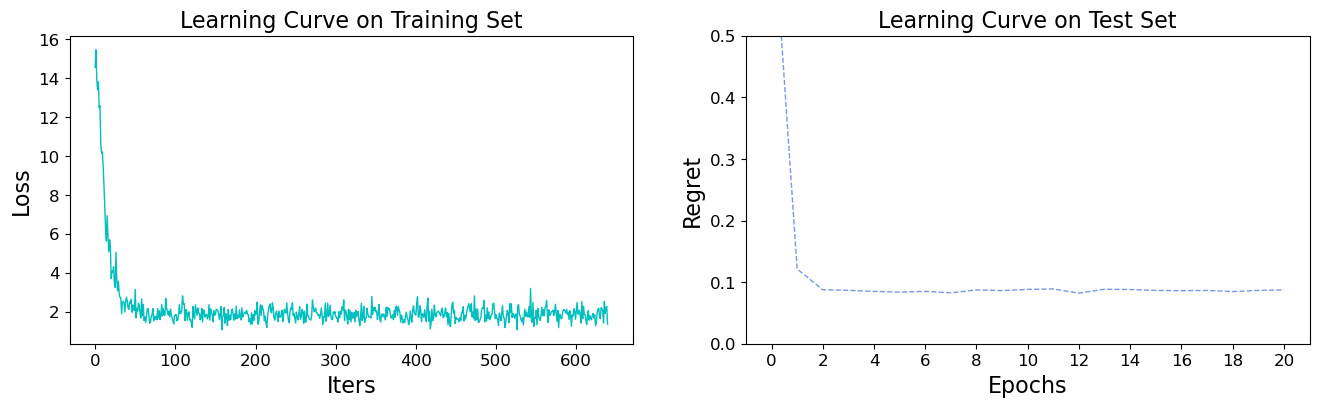

In [45]:
visLearningCurve(loss_log, loss_log_regret)

Differentiable Black-Box Solver

In [47]:
import torch
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

``pyepo.func.blackboxOpt`` allows us to set a differentiable solver, which requires parameters:
- ``optmodel``: a PyEPO optimization model
- ``lambd``: a parameter to contral interpolation degree
- ``processes``: number of processors for multi-thread, 1 for single-core, 0 for all of the cores

In [49]:
# init dbb solver
dbb = pyepo.func.blackboxOpt(optmodel, lambd=20, processes=2)
# set loss
l1 = nn.L1Loss()

# loss function
def dbbl1(cp, c, z):
    # black-box optimizer
    wp = dbb(cp)
    # objective value
    zp = (wp * c).sum(1).view(-1, 1)
    # loss
    loss = l1(zp, z)
    return loss

Num of cores: 2


Entrenamiento

In [51]:
loss_log, loss_log_regret = trainModel(reg, loss_func=dbbl1, method_name="dbb")

Epoch  1,  Loss:    1.4674,  Regret: 33.3757%
Epoch  2,  Loss:    0.9634,  Regret: 22.5669%
Epoch  3,  Loss:    0.8256,  Regret: 15.7709%
Epoch  4,  Loss:    0.4472,  Regret: 13.3059%
Epoch  5,  Loss:    0.0956,  Regret: 11.8467%
Epoch  6,  Loss:    0.7436,  Regret: 11.4116%
Epoch  7,  Loss:    0.6158,  Regret: 10.9810%
Epoch  8,  Loss:    0.3790,  Regret: 11.5672%
Epoch  9,  Loss:    0.7633,  Regret: 11.1327%
Epoch 10,  Loss:    0.3770,  Regret: 11.5402%
Epoch 11,  Loss:    0.4911,  Regret: 11.0425%
Epoch 12,  Loss:    0.5130,  Regret: 12.4792%
Epoch 13,  Loss:    0.5988,  Regret: 10.9631%
Epoch 14,  Loss:    0.3623,  Regret: 11.3348%
Epoch 15,  Loss:    0.3875,  Regret: 12.2114%
Epoch 16,  Loss:    0.4099,  Regret: 12.1870%
Epoch 17,  Loss:    0.1095,  Regret: 12.3166%
Epoch 18,  Loss:    0.2592,  Regret: 11.3626%
Epoch 19,  Loss:    0.2618,  Regret: 11.9917%
Epoch 20,  Loss:    0.3849,  Regret: 12.4739%
Total Elapsed Time: 3396.83 Sec.


Curva de aprendizaje

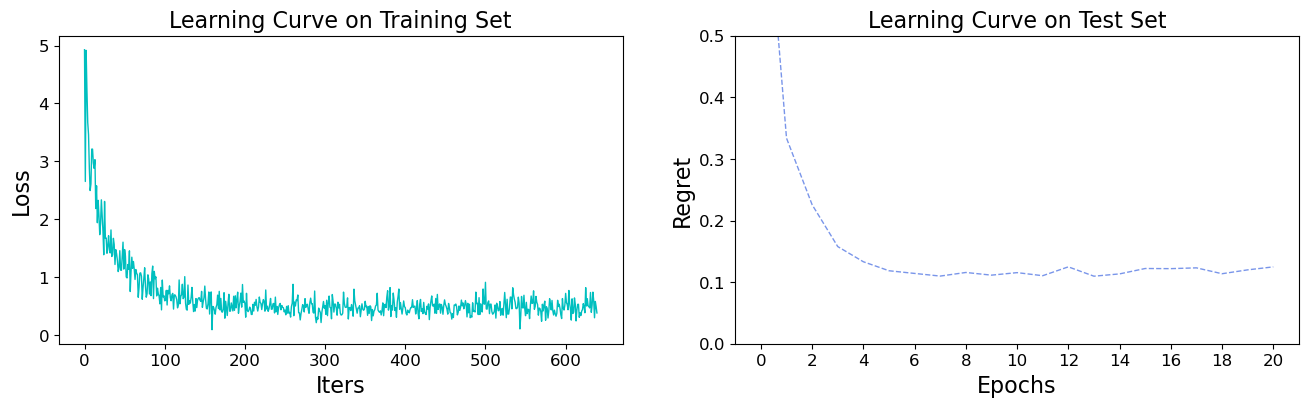

In [53]:
visLearningCurve(loss_log, loss_log_regret)

-Differentiable Perturbed Optimizer 

In [55]:
import torch
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

``pyepo.func.perturbedOpt`` allows us to set a SPO+ loss for training, which requires parameters:
- ``optmodel``: a PyEPO optimization model
- ``n_samples``: number of Monte-Carlo samples
- ``sigma``:  the amplitude of the perturbation for costs
- ``processes``: number of processors for multi-thread, 1 for single-core, 0 for all of the cores
- ``seed``: random state seed for perturbations

In [61]:
# init ptb solver
ptb = pyepo.func.perturbedOpt(optmodel, n_samples=3, sigma=1.0, processes=2)
# set loss
l1 = nn.L1Loss()

# loss function se tiene que definir un funcion de perdida ya que en ptb no viene incluida
def ptbl1(cp, w):
    # perturbed optimizer
    we = ptb(cp)
    # loss
    loss = l1(we, w)
    return loss

Num of cores: 2


In [62]:
loss_log, loss_log_regret = trainModel(reg, loss_func=ptbl1, method_name="ptb")

Epoch  1,  Loss:    0.2440,  Regret: 69.9067%
Epoch  2,  Loss:    0.2044,  Regret: 60.0396%
Epoch  3,  Loss:    0.1905,  Regret: 54.4278%
Epoch  4,  Loss:    0.1885,  Regret: 48.9243%
Epoch  5,  Loss:    0.2024,  Regret: 45.5698%
Epoch  6,  Loss:    0.1925,  Regret: 41.7071%
Epoch  7,  Loss:    0.1419,  Regret: 38.7254%
Epoch  8,  Loss:    0.2262,  Regret: 35.1658%
Epoch  9,  Loss:    0.1647,  Regret: 31.6949%
Epoch 10,  Loss:    0.1518,  Regret: 29.3111%
Epoch 11,  Loss:    0.1270,  Regret: 27.2881%
Epoch 12,  Loss:    0.1677,  Regret: 24.7144%
Epoch 13,  Loss:    0.1369,  Regret: 22.5988%
Epoch 14,  Loss:    0.1468,  Regret: 21.3558%
Epoch 15,  Loss:    0.2083,  Regret: 20.2907%
Epoch 16,  Loss:    0.1627,  Regret: 19.1147%
Epoch 17,  Loss:    0.1369,  Regret: 18.9664%
Epoch 18,  Loss:    0.1349,  Regret: 18.0876%
Epoch 19,  Loss:    0.1518,  Regret: 17.6672%
Epoch 20,  Loss:    0.1270,  Regret: 16.6651%
Total Elapsed Time: 3317.42 Sec.


Curva de apredizaje

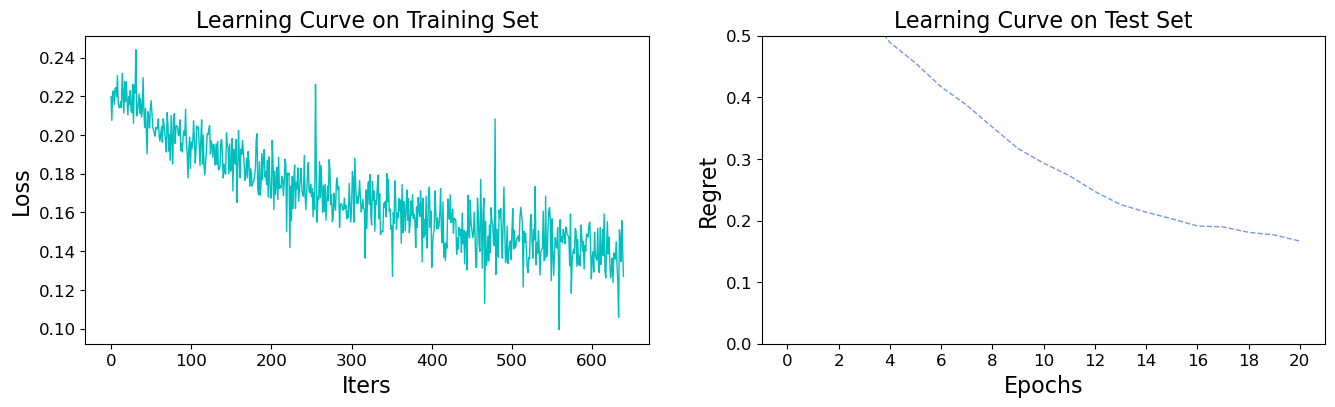

In [64]:
visLearningCurve(loss_log, loss_log_regret)

Perturbed Fenchel-Young Loss 

In [71]:
pfy = pyepo.func.perturbedFenchelYoung(optmodel, n_samples=10, sigma=0.5, processes=2)

Num of cores: 2


In [72]:
import torch
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()

``pyepo.func.perturbedFenchelYoung`` allows us to set a Fenchel-Young loss for training, which requires parameters:
- ``optmodel``: a PyEPO optimization model
- ``n_samples``: number of Monte-Carlo samples
- ``sigma``:  the amplitude of the perturbation for costs
- ``processes``: number of processors for multi-thread, 1 for single-core, 0 for all of the cores
- ``seed``: random state seed for perturbations

In [74]:
# init pfyl loss
pfy = pyepo.func.perturbedFenchelYoung(optmodel, n_samples=3, sigma=1.0, processes=2)

Num of cores: 2


Entrenamiento

In [76]:
loss_log, loss_log_regret = trainModel(reg, loss_func=pfy, method_name="pfy")

Epoch  1,  Loss:   10.8611,  Regret: 13.8672%
Epoch  2,  Loss:    6.6111,  Regret:  9.7458%
Epoch  3,  Loss:    8.1944,  Regret:  9.0233%
Epoch  4,  Loss:    8.2778,  Regret:  8.5850%
Epoch  5,  Loss:    9.3889,  Regret:  8.8058%
Epoch  6,  Loss:    7.1389,  Regret:  8.4313%
Epoch  7,  Loss:    7.1944,  Regret:  8.2251%
Epoch  8,  Loss:    7.7778,  Regret:  8.1547%
Epoch  9,  Loss:    3.1111,  Regret:  8.3077%
Epoch 10,  Loss:    6.4722,  Regret:  8.2902%
Epoch 11,  Loss:    9.6111,  Regret:  8.0927%
Epoch 12,  Loss:    8.7222,  Regret:  8.3234%
Epoch 13,  Loss:    7.1389,  Regret:  8.1241%
Epoch 14,  Loss:    8.7500,  Regret:  8.3810%
Epoch 15,  Loss:    5.5833,  Regret:  8.3233%
Epoch 16,  Loss:    9.0833,  Regret:  8.5040%
Epoch 17,  Loss:    5.7778,  Regret:  8.3271%
Epoch 18,  Loss:    7.1389,  Regret:  8.5381%
Epoch 19,  Loss:    5.6944,  Regret:  8.2189%
Epoch 20,  Loss:    7.5278,  Regret:  8.2904%
Total Elapsed Time: 2942.16 Sec.


Curva de aprendizaje

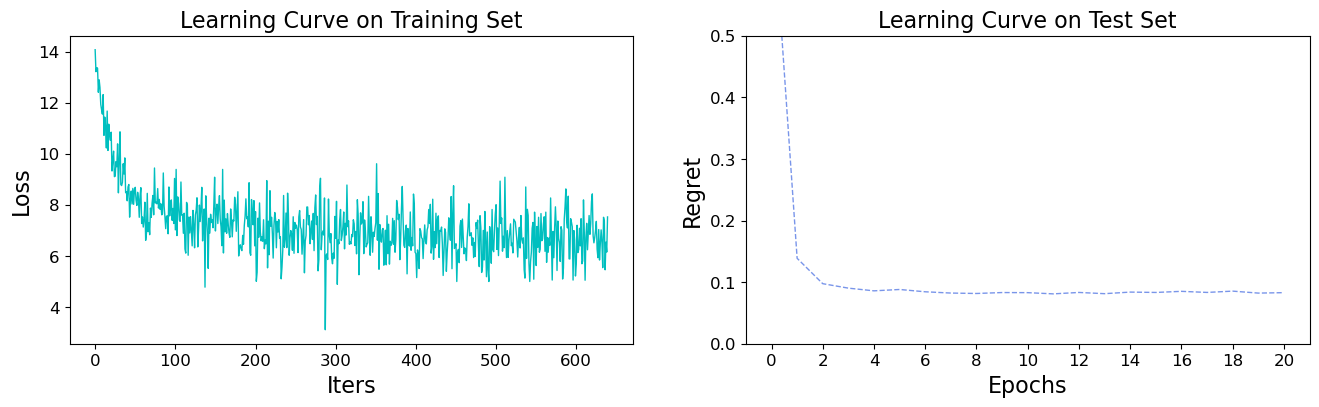

In [78]:
visLearningCurve(loss_log, loss_log_regret)